<a href="https://colab.research.google.com/github/annhater/isdd_projects/blob/main/ai_2/Anna_PEROVA_TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Introduction to Dense and CNN for secondary structure prediction

**About the project:**
* Here, we're trying to predict the secondary structure of a protein.
* We are categorizing each amino acid in a protein into one of three structural classes:
  * H (Alpha-Helix)
  * E (Beta-Strand)
  * C (Coil)
* We're using a Position-Specific Scoring Matrix (PSSM), that tells us how much a specific position in a protein has changed over in course of evolution.
* By looking at a window of 15 amino acids, the CNN can "see" several turns of a helix or a Beta-strand to make an informed decision based on the neighbours.

**Goal:**

* Buld a model that undestands context:
  * Dense ANN: Treats the 15-residue window as a flat list of numbers. It does not understand the relashionship between the neighbours.
  * CNN ResNet uses it's filters to scan the sequence and allows to
* As you stack layers, the gradient (the signal to learn) can vanish. The "shortcut" allows the gradient to flow through the network more easily, allowing you to train much deeper models.





##Example 1 : Secondary structure prediction

First, import some modules necessary for data analysis and transformation:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import requests
from tqdm.auto import tqdm

Mount google drive:

In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd  /content/drive/MyDrive
%mkdir M2BI_DRIVE
%cd  /content/drive/MyDrive/M2BI_DRIVE
%pwd

Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘M2BI_DRIVE’: File exists
/content/drive/MyDrive/M2BI_DRIVE


'/content/drive/MyDrive/M2BI_DRIVE'

In [3]:
def download_data():
  x_pssm500_DatasetTrainUrl    ='https://www.dsimb.inserm.fr/~gelly/data/x_pssm500.csv';
  x_aaindex500_DatasetValidUrl ='https://www.dsimb.inserm.fr/~gelly/data/x_aaindex500.csv';
  y_bfact_DatasetTrainUrl      ='https://www.dsimb.inserm.fr/~gelly/data/y_bfact500.csv';
  y_class_DatasetValidUrl      ='https://www.dsimb.inserm.fr/~gelly/data/y_class500.csv';
  datasetFolderPath = "dataset/"

  trainpssmFilePath     = os.path.join(datasetFolderPath, 'x_pssm500.csv')
  trainaaindexFilePath  = os.path.join(datasetFolderPath, 'x_aaindex500.csv')
  yclassFilePath        = os.path.join(datasetFolderPath, 'y_class500.csv')
  ybfactFilePath        = os.path.join(datasetFolderPath, 'y_bfact500.csv')


  if not os.path.exists(datasetFolderPath):
    os.makedirs(datasetFolderPath)

  def download_file(url, filename):
    response = requests.get(url, stream=True)
    with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                       total=int(response.headers.get('content-length', 0)),
                       desc=filename) as fout:
                       for chunk in response.iter_content(chunk_size=4096):
                         fout.write(chunk)

  if not os.path.exists(trainpssmFilePath):
    download_file(x_pssm500_DatasetTrainUrl, trainpssmFilePath)

  if not os.path.exists(trainaaindexFilePath):
    download_file(x_aaindex500_DatasetValidUrl, trainaaindexFilePath)

  if not os.path.exists(yclassFilePath):
    download_file(y_class_DatasetValidUrl, yclassFilePath)

  if not os.path.exists(ybfactFilePath):
    download_file(y_bfact_DatasetTrainUrl, ybfactFilePath)



In [4]:
download_data()

Read the data to variables (it will take some time for x since we have a lot of data):

In [5]:
X = np.loadtxt('dataset/x_pssm500.csv')

In [6]:
print(f'{X[0:10]}')
print(f'{X.shape}')

[[0.     0.     0.     ... 0.0159 0.188  0.    ]
 [0.     0.     0.     ... 0.0196 0.1862 0.    ]
 [0.     0.     0.     ... 0.0445 0.1348 0.    ]
 ...
 [0.05   0.0054 0.0501 ... 0.0885 0.0642 0.    ]
 [0.0536 0.0059 0.0523 ... 0.0172 0.096  0.    ]
 [0.0525 0.0058 0.0536 ... 0.0179 0.0772 0.    ]]
(99083, 330)


In [7]:
Y = np.loadtxt('dataset/y_class500.csv')

In [8]:
YB =  np.loadtxt('dataset/y_bfact500.csv')

In [9]:
Y_class =  np.loadtxt('dataset/y_class500.csv')

In [10]:
# cmap = plt.cm.get_cmap('PiYG', 7)

# Data analysis

How many examples do we have in our dataset?

In [11]:
print(f'X:\n {X}\nY:\n{Y}')
print(f'Shape of data X:{X.shape}\n')
print(f'Shape of data Y:{Y.shape}\n')

X:
 [[0.     0.     0.     ... 0.0159 0.188  0.    ]
 [0.     0.     0.     ... 0.0196 0.1862 0.    ]
 [0.     0.     0.     ... 0.0445 0.1348 0.    ]
 ...
 [0.052  0.0055 0.0503 ... 0.     0.     1.    ]
 [0.0509 0.0055 0.0552 ... 0.     0.     1.    ]
 [0.0506 0.0058 0.0503 ... 0.     0.     1.    ]]
Y:
[6. 3. 3. ... 3. 6. 6.]
Shape of data X:(99083, 330)

Shape of data Y:(99083,)



We have 99083 examples.

We will simplify our data for the first tests using only three types of SS. Once everything works, you can get back to the initial data.

In [12]:
Y3cl = np.zeros(len(Y))
Y3cl[((Y==0) | (Y==1) | (Y==2))] = 0 # helix H
Y3cl[((Y==3) | (Y==4))] = 1          # strand E
Y3cl[((Y==5) | (Y==6))] = 2          # coil C

In [13]:
# Frequency
print(f'Number of Helices: {sum(Y3cl==0)}\n')
print(f'Number of Strands: {sum(Y3cl==1)}\n')
print(f'Number of Coils: {sum(Y3cl==2)}\n')

Number of Helices: 40657

Number of Strands: 23022

Number of Coils: 35404



What is our class distribution?

<BarContainer object of 3 artists>

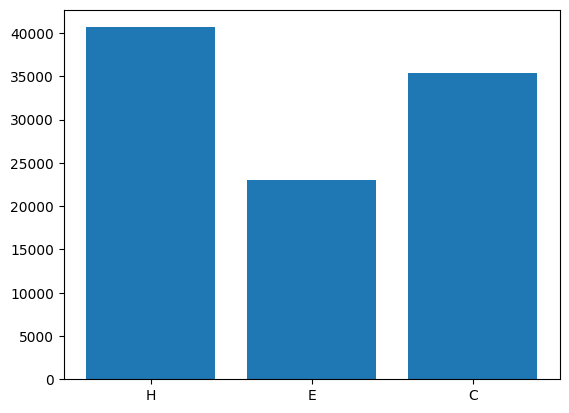

In [14]:
unique, counts = np.unique(Y3cl, return_counts=True)
plt.bar(["H", "E", "C"], counts)

The dataset is unbalanced => we will need to implement

# Prediction model

## Preparation

We import some modules for deep learning model construction.

In [15]:
!pip install scikeras

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D, Flatten
from scikeras.wrappers import KerasClassifier
#from keras.wrappers.scikit_learn import KerasClassifier
# Utily function from keras
#from keras.utils import np_utils
# Plot model
#from keras.utils import plot_model
# Optimizers
from tensorflow.keras import optimizers

# Useful Sklearn library
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import sklearn.metrics

from keras.utils import to_categorical
from keras.utils import plot_model

One hot encoding of class Y

In [17]:
y_oh = to_categorical(Y3cl)
print(f'One hot encoding of y : {y_oh}\n')
print(f'Shape of y_oh : {y_oh.shape}')

One hot encoding of y : [[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]

Shape of y_oh : (99083, 3)


To successfully use CNN, we need to convert our data:

In [18]:
print(f'X shape : {X.shape}')
x_cnn = X.reshape(len(X), 15, 22)
print(f'X reshaped : {x_cnn.shape}')

X shape : (99083, 330)
X reshaped : (99083, 15, 22)


We will also prepare our data for training by splitting data into train and validation sets:

In [19]:
#shuffle_bol=np.bool(1)
X_train,X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.2, random_state=3, shuffle=True)
Xcnn_train, Xcnn_test, y_train, y_test = train_test_split(x_cnn, y_oh, test_size=0.2, random_state=3, shuffle=True)

## Model definition

## Classification

### First try with dense

Simple ANN:

In [38]:
# create first NN in sequential mode
model = Sequential()
model.add(Dense(10, input_dim=330, activation="sigmoid"))
model.add(Dense(4, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 10)             │         3,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,369 (13.16 KB)

 Trainable params: 3,369 (13.16 KB)

 Non-trainable params: 0 (0.00 B)

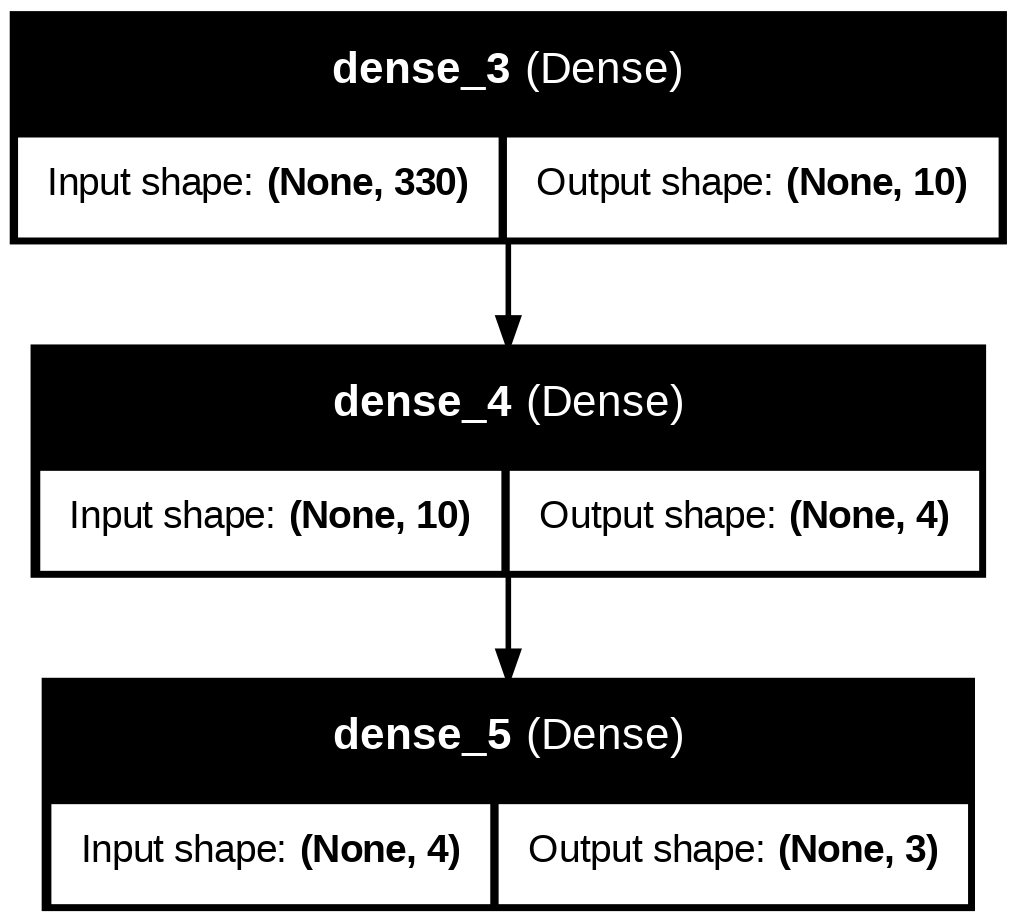

In [41]:
plot_model(model, to_file="model.png",
               show_shapes=True, show_layer_names=True)

In [42]:
history=model.fit(X,y_oh, epochs=15, validation_split=0.2,batch_size=16, verbose=1)

Epoch 1/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.4942 - loss: 1.0092 - val_accuracy: 0.6895 - val_loss: 0.7530
Epoch 2/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7164 - loss: 0.7012 - val_accuracy: 0.7036 - val_loss: 0.7149
Epoch 3/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7298 - loss: 0.6602 - val_accuracy: 0.7106 - val_loss: 0.6984
Epoch 4/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7350 - loss: 0.6521 - val_accuracy: 0.7160 - val_loss: 0.6864
Epoch 5/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7351 - loss: 0.6489 - val_accuracy: 0.7124 - val_loss: 0.6917
Epoch 6/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7361 - loss: 0.6485 - val_accuracy: 0.7136 - val_loss: 0.6897
Epoch 7/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7387 - loss: 0.6458 - val_accuracy: 0.7151 - val_loss: 0.6869
Epoch 8/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7397 - loss: 0

1. Did the model successfully train? Plot different metrics and evolution of train/validation loss.

- We observe that for both train, accuracy function increases whereas the loss function decreases. For validation set, we mostly observe a mostly stagnant function, wich means the model does not learn a lot on validation set. We reach maximum accuracy of 0.72, and 0.68 of loss function, which is high, and indicates that the model could be improved.

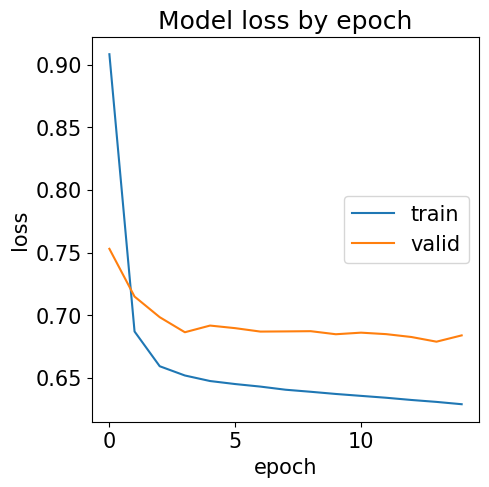

In [44]:
# Loss evolution
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Dense Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

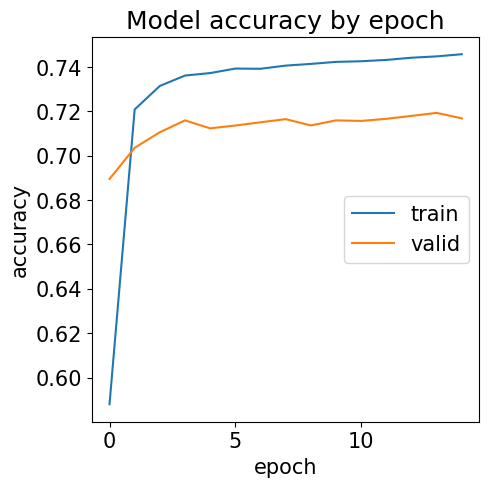

In [45]:
#Plot Accuracy
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Dense Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

2. How does the model perform for the independent test ? (Plot Accuracy, Loss, Confusion matrix (Frequencies) [TIPS: Use seaborn heatmap]

620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<Axes: >

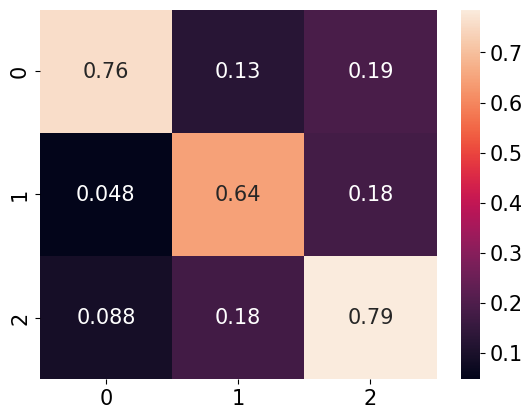

In [46]:
import seaborn as sns
confusion_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1),
                                                    np.argmax(model.predict(X_test), axis=1))
sns.heatmap(confusion_matrix/confusion_matrix.sum(axis=1), annot = True) #plots frequency

<Axes: >

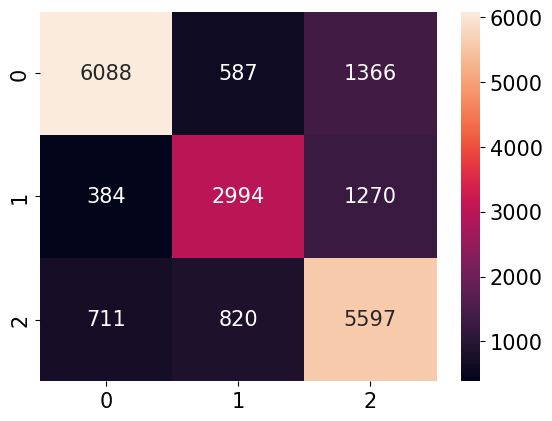

In [47]:
sns.heatmap(confusion_matrix, annot=True, fmt = 'd') #plots occurences

By using the heatmap, we see (the diagonal of bright colors) that overall the model correctly predicts the correct classes (2d structures). However, there is still a big portion of the false positives/wrongly assigned classes. We also see another issue: our data is unbalanced and therefore we have less observations for class 1 (E)

3. What is the problem with a unique test set ? How can we resolve this problem ? Try to implement a approach to overcome this problem. [TIPS: Use sklearn]
- Use K-Fold Cross-Validation. This splits the data into K parts and trains/tests K times so every data point is used for testing once.

4. Try a different architecture: Convolutional network and measure performance

In [52]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
model = Sequential()

# Layer 1
model.add(Conv1D(32, 3, padding="same", activation='relu', kernel_initializer='he_uniform', input_shape=(15, 22))) # Corrected input_shape to match x_cnn
model.add(MaxPooling1D(2))

# Layer 2
model.add(Conv1D(32, (3), padding="same", activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling1D(2))

# Dense Layers
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.summary()

#compile
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') # Changed loss to categorical_crossentropy

# training CNN
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

history_cnn = model.fit(
    Xcnn_train, y_train,
    validation_data=(Xcnn_test, y_test),
    epochs=50,
    callbacks=[early_stop],
    verbose=2
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 15, 32)         │         2,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,451 (33.01 KB)

 Trainable params: 8,451 (33.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2478/2478 - 16s - 6ms/step - accuracy: 0.7107 - loss: 0.6814 - val_accuracy: 0.7532 - val_loss: 0.5886
Epoch 2/50
2478/2478 - 10s - 4ms/step - accuracy: 0.7650 - loss: 0.5757 - val_accuracy: 0.7570 - val_loss: 0.5864
Epoch 3/50
2478/2478 - 13s - 5ms/step - accuracy: 0.7766 - loss: 0.5477 - val_accuracy: 0.7782 - val_loss: 0.5346
Epoch 4/50
2478/2478 - 12s - 5ms/step - accuracy: 0.7858 - loss: 0.5274 - val_accuracy: 0.7576 - val_loss: 0.5714
Epoch 5/50
2478/2478 - 10s - 4ms/step - accuracy: 0.7896 - loss: 0.5172 - val_accuracy: 0.7847 - val_loss: 0.5214
Epoch 6/50
2478/2478 - 8s - 3ms/step - accuracy: 0.7932 - loss: 0.5067 - val_accuracy: 0.7896 - val_loss: 0.5072
Epoch 7/50
2478/2478 - 9s - 4ms/step - accuracy: 0.7979 - loss: 0.4970 - val_accuracy: 0.7900 - val_loss: 0.5086
Epoch 8/50
2478/2478 - 8s - 3ms/step - accuracy: 0.8011 - loss: 0.4911 - val_accuracy: 0.7943 - val_loss: 0.4991
Epoch 9/50
2478/2478 - 10s - 4ms/step - accuracy: 0.8034 - loss: 0.4847 - val_accuracy: 0.7

5. What do you think about model performances? Check per-class model performance. Compare to Dense neural network

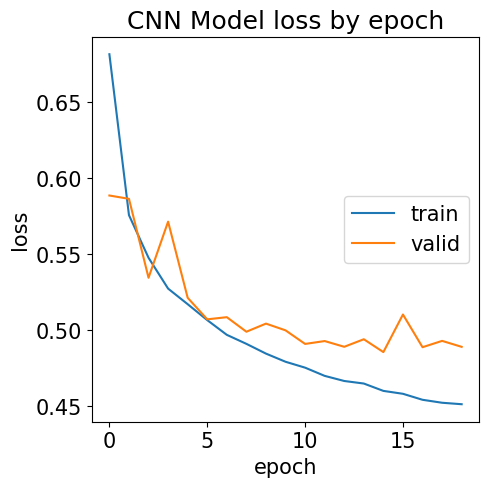

In [60]:
#Plot loss
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('CNN Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

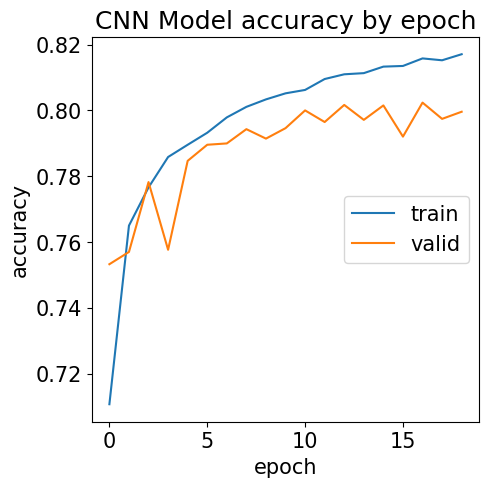

In [61]:
#Plot Accuracy
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('CNN Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

The CNN model showed an increasing accuracy reaching 0.81 for training and 0.80 for vadidation set, while the loss decreased to around 0.4 in both cases. This indicates that the model is better at learning from the training data. The EarlyStopping allowed us to find the optimal number of epochs (epochs = 19).

We also notice a lot of peaks for accuracy and loss graphs by epochs. This could indicate

Compared to the initial dense neural network, this model have achieved better accuracy and lower loss, meaning overall improvement of prediction. This is expected, since CNN models are usually better at capturing local patterns.


620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix (CNN):
 [[6904  124 1013]
 [ 145 3354 1149]
 [ 726  776 5626]]

Classification report (CNN):
               precision    recall  f1-score   support

           H     0.8880    0.8586    0.8730      8041
           E     0.7884    0.7216    0.7535      4648
           C     0.7224    0.7893    0.7544      7128

    accuracy                         0.8015     19817
   macro avg     0.7996    0.7898    0.7936     19817
weighted avg     0.8051    0.8015    0.8023     19817



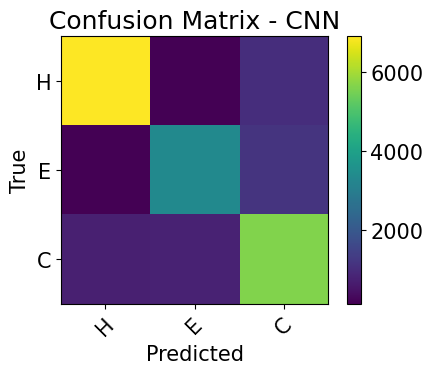

In [57]:
import seaborn as sns
from sklearn.metrics import classification_report # Import classification_report

class_names = ['H', 'E', 'C']

# Get predictions
y_pred_proba_cnn = model.predict(Xcnn_test)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# Convert y_test (one-hot encoded) back to class labels
y_true_cnn = np.argmax(y_test, axis=1)

cm_cnn = sklearn.metrics.confusion_matrix(y_true_cnn,
                                                    y_pred_cnn)
print("Confusion matrix (CNN):\n", cm_cnn)
print("\nClassification report (CNN):\n",
      classification_report(y_true_cnn, y_pred_cnn, target_names=class_names, digits=4))

plt.figure(figsize=(5,4))
plt.imshow(cm_cnn, interpolation="nearest")
plt.title("Confusion Matrix - CNN")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

Here, we observe that alpha-helic (H) class is most correctly predicted, with precicion of 0.89, and a strong f1-score of 0.87. This means when the model predicts 'H', it's usually correct and we can mostly trust it.
The model has more difficulties with beta-strands (E) and coils (C), while still having elevated precision scores: 0.79 and 0.72, respectively. This means that the model predicts more false negatives for these classes.

6. How could you overcome the problem of different class population ?
- Oversampling: Duplicating samples of the minority class (Strands).
- Undersampling: Removing samples of the majority class (Helices).
- A loss function that "down-weights" easy examples and focuses the model on hard-to-learn classes

In [63]:
from sklearn.utils import class_weight
calculated_class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(Y3cl),
    y = Y3cl)

class_weights_dict = dict(enumerate(calculated_class_weights))

print(f"Class weights {class_weights_dict}\n")

Class weights {0: np.float64(0.8123488370186356), 1: np.float64(1.4346132684678423), 2: np.float64(0.9328795239709261)}



7. What is the problem if we let the training continue for too many epochs ?
- This leads to Overfitting. The model begins to memorize the specific training sequences rather than learning the general physical rules of protein folding.

8. And if we try to predict the B-factor, what changes do we need to make?
- Output layer: Dense(1) with a linear activation (or no activation).
- Loss function: MSE (Mean Squared Error) or MAE.
- Interpretation: The model now outputs a continuous value representing atom displacement/flexibility rather than a category.

9. How can we implement a complex architecture ? [TIPS: Functionnal API]

The Functional API works like a network and allows for "skip connections" (adding x to f(x)), which helps to build a more complex architecture.

10. Implement CNN Resnet

In [64]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def residual_block(x_input, channels, kernel_size=3):
    # 1. Create the shortcut (the "identity" or "projection")
    x_shortcut = x_input

    # If the input channels != output channels, we must project the shortcut
    # to the same dimension using a 1x1 convolution.
    if x_input.shape[-1] != channels:
        x_shortcut = Conv1D(channels, kernel_size=1, padding='same')(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)

    # 2. The main path (BatchNorm -> ReLU -> Conv)
    x = BatchNormalization()(x_input)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size, padding='same')(x)

    # 3. Add the shortcut back to the main path
    x = Add()([x, x_shortcut])
    return x

# Building the model
inputs = Input(shape=(15, 22))
x = Conv1D(32, kernel_size=3, padding='same')(inputs) # Initial projection to 32 channels

for i in range(5): # 5 Blocks
    x = residual_block(x, channels=32)

x = GlobalAveragePooling1D()(x) # Flattening the sequence info
x = Dense(32, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
history = model.fit(Xcnn_train, y_train,
                    epochs=15,
                    batch_size=16,
                    validation_data=(Xcnn_test, y_test), # we should use the split data that we made before
                    verbose=1)

Epoch 1/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.6875 - loss: 0.7057 - val_accuracy: 0.7797 - val_loss: 0.5295
Epoch 2/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.7816 - loss: 0.5371 - val_accuracy: 0.8061 - val_loss: 0.4750
Epoch 3/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.7977 - loss: 0.4876 - val_accuracy: 0.8106 - val_loss: 0.4683
Epoch 4/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8083 - loss: 0.4690 - val_accuracy: 0.8070 - val_loss: 0.4721
Epoch 5/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8189 - loss: 0.4450 - val_accuracy: 0.8178 - val_loss: 0.4419
Epoch 6/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8240 - loss: 0.4301 - val_accuracy: 0.8200 - val_loss: 0.4387
Epoch 7/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8352 - loss: 0.4081 - val_accuracy: 0.8221 - val_loss: 0.4425
Epoch 8/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8367 - loss: 0

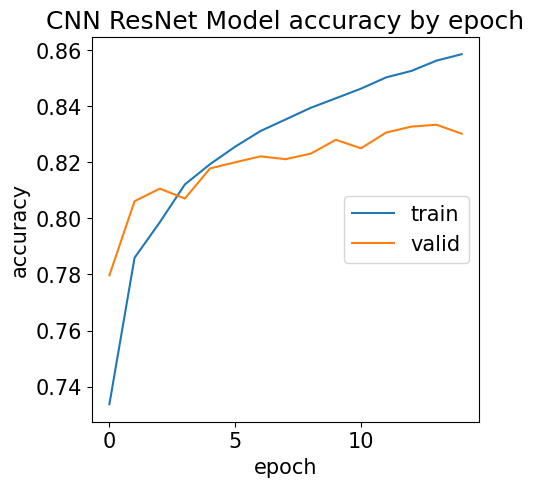

In [70]:
#Plot Accuracy
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN ResNet Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

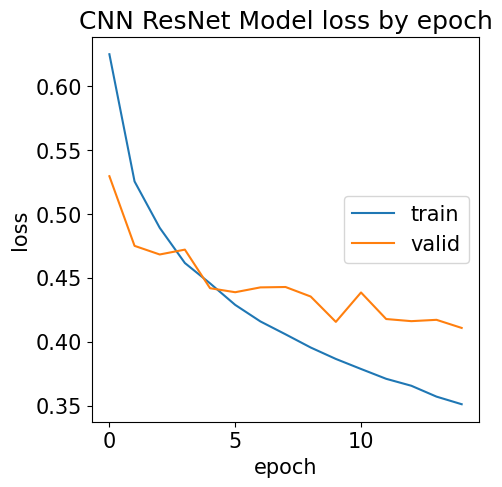

In [71]:
#Plot loss
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN ResNet Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

We observe a smooth learning curve for train dataset, that reaches accuracy of 0.89 by epoch 15. For the validation dataset the learning curve is less smooth and has a lower accuracy performance of 0.82, but still has better metrics than previously developped models. Similarly, the model loss is lower for training and reaches 0.35, while for validation dataset it is a bit higher, around 0.40. These metrics indicate that the model is not over-fitting, and is capable of leaining.


620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<Axes: >

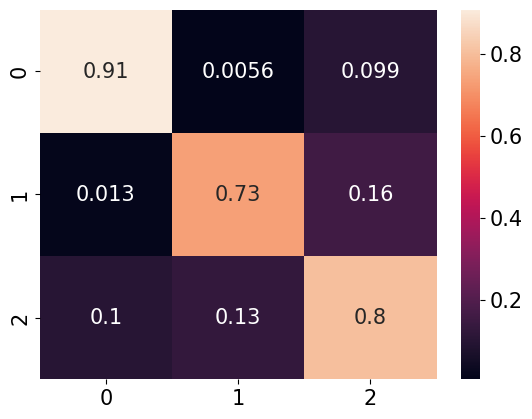

In [72]:
import seaborn as sns
confusion_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1),
                                                    np.argmax(model.predict(Xcnn_test), axis=1))
sns.heatmap(confusion_matrix/confusion_matrix.sum(axis=1), annot = True) #plots frequency

<Axes: >

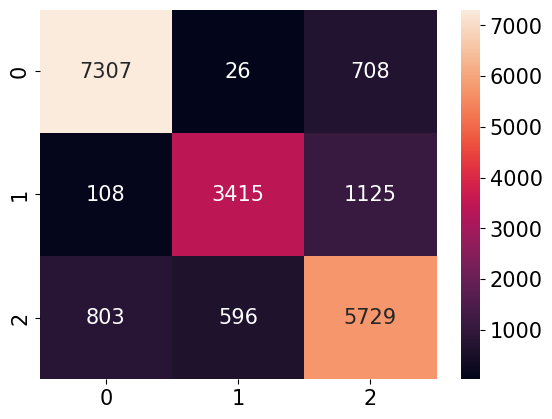

In [73]:
sns.heatmap(confusion_matrix, annot=True, fmt = 'd') #plots occurences

By looking at the confusion matrix we see that with CNN-ResNet model, like we've expected we see an augmentation of correctly predicted observations for each class and decrease of false positives.

Conclusion:
- Here, we've used three types of NN models: ANN, CNN and CNN-ResNet
- ANN achieved accuracy of 71%, but showed learning curve stagnation quite early due to its inability of understanding spacial context (treats data like flat list)
- Using CNN model showed significant improvement, reaching 81% of accuracy. Meaning it is better at understanding precise local patters (uses kernel)
- With implementation of residual blocks (ResNet) to our CNN model, allowed us to increase the accuracy up to 83%. The addition of residual blocks allowed for the training without the vanishing gradient problem.

For secondary structure prediction using PSSM data, architectures that are capable of understanding local information, such as CNN models, are superior. This practical, allowed us to see the differences between models and implement ResNet architecture into CNN model to get better predictions.